<a href="https://colab.research.google.com/github/VJsai45/Number-Generation-using-GAN/blob/main/GAN_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import torch

In [ ]:
mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()



In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28,28)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10,activation='softmax'),                                    
])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls /content/gdrive/My\ Drive

model_save_name = 'Test saving'
path = F"/content/gdrive/My Drive/"+model_save_name
model.save(path)

In [ ]:
saved_model = tf.keras.models.load_model(path)


Epoch 1/2
1875/1875 [==============================] - 5s 3ms/step - loss: 1.3462 - accuracy: 0.7524 - val_loss: 0.6089 - val_accuracy: 0.7824
Epoch 2/2
1875/1875 [==============================] - 5s 2ms/step - loss: 0.5314 - accuracy: 0.8167 - val_loss: 0.5383 - val_accuracy: 0.8258


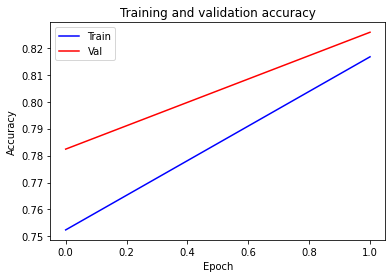

In [ ]:
# Add a validatin set
history = model.fit(x=x_train,y=y_train, validation_data=(x_test,y_test),epochs=2)

# Get stats from history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

# Plot accuracy vs epochs
plt.title('Training and validation accuracy')
plt.plot(epochs,acc,color='blue', label='Train')
plt.plot(epochs,val_acc,color='red', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')                                                                                    
plt.legend()


In [ ]:
# Image Classification

fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

print(train_images.shape)

In [ ]:
plt.figure()
plt.imshow(train_images[00])
plt.colorbar()
plt.show()

In [ ]:
train_images = train_images/255.0
test_images = test_images/255.0



In [ ]:
plt.figure(figsize=(10,10))
for i in range(36):
  plt.subplot(6,6,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(train_images[i],cmap=plt.cm.binary)
  plt.xlabel(class_names[train_labels[i]])


In [ ]:
## Actual Implementation GAN
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time 
from IPython import display

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
print(train_images.shape)

In [ ]:
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
print(train_images.shape)
train_images = (train_images - 127.5) / 127.5

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

#train_images = tf.slice(train_images,[0,0,0,0],[12000,28,28,1])

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)



In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    #assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
   # assert model.output_shape == (None, 7, 7, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
   # assert model.output_shape == (None, 14, 14, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation= tf.keras.activations.tanh))
   # assert model.output_shape == (None, 28, 28, 1)

    return model

In [ ]:
generator = make_generator_model()
noise = tf.random.normal([1,100])

generated_image = generator(noise, training=False)

plt.imshow(generated_image[0,:,:,0], cmap='gray')


In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    print(model.output_shape)
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    print(model.output_shape)
    model.add(tf.keras.layers.Flatten())
    print(model.output_shape)
    model.add(tf.keras.layers.Dense(1))
    print(model.output_shape)
    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(generated_image[0].shape)
print(decision)


(None, 14, 14, 64)
(None, 7, 7, 128)
(None, 6272)
(None, 1)
(28, 28, 1)
tf.Tensor([[0.00148673]], shape=(1, 1), dtype=float32)


In [ ]:
crossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits='true')


In [ ]:
def discriminator_loss(real_output,fake_output):
  real_loss = crossEntropy(tf.ones_like(real_output),real_output)
  fake_loss = crossEntropy(tf.zeros_like(fake_output),fake_output)
  total_loss = real_loss + fake_loss
  return total_loss


In [ ]:
def generator_loss(fake_output):
  loss = crossEntropy(tf.ones_like(fake_output),fake_output)
  return loss


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate,noise_dim])


In [ ]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE,noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_fake_output = generator(noise,training =True)
    disc_real_output = discriminator(images,training =True)
    disc_fake_output = discriminator(gen_fake_output,training =True)

    gen_loss = generator_loss(disc_fake_output)
    disc_loss = discriminator_loss(disc_real_output,disc_fake_output)
    

  gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
  
  generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))

    

In [ ]:
def train(dataset,epochs):
  for epoch in range(epochs):
    start = time.time()
    counter=0;
   
    for image_batch in dataset:
      train_step(image_batch)
      counter+=1
      print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start),counter)
      # Produce images fot the GIF as we go
      display.clear_output(wait=True)
      generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    # Save the model every 15 epochs
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    model_name_1 = 'Gan_Generator_MNIST'
    model_name_2 = 'Gan_Discriminator_MNIST'
    path1 = F"/content/gdrive/My Drive/"+model_name_1
    path2 = F"/content/gdrive/My Drive/"+model_name_2
    generator.save(path1)
    discriminator.save(path2)
    

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
      plt.title(i)

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  return predictions

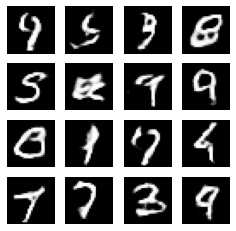

In [ ]:
print(generator.metrics)
train(train_dataset, EPOCHS)


In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [ ]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


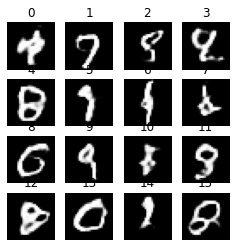

[[-0.35391232]
 [-0.5188239 ]
 [-0.4991779 ]
 [-0.7210972 ]
 [-1.2407092 ]
 [-0.19007261]
 [ 0.21949063]
 [-0.32907143]
 [-0.01464611]
 [ 0.00263508]
 [-0.7724729 ]
 [ 0.028739  ]
 [-0.582188  ]
 [-0.01553669]
 [ 0.34148172]
 [-0.40846214]]


In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')

model_name_1 = 'Gan_Generator_MNIST'
path1 = F"/content/gdrive/My Drive/"+model_name_1
model_name_2 = 'Gan_Discriminator_MNIST'
path2 = F"/content/gdrive/My Drive/"+model_name_2
saved_generator = tf.keras.models.load_model(path1)
saved_discriminator = tf.keras.models.load_model(path2)
saved_generator.compile(optimizer=tf.keras.optimizers.Adam(1e-4),loss=tf.keras.losses.BinaryCrossentropy(from_logits='true'),metrics=['accuracy'])
saved_discriminator.compile(optimizer=tf.keras.optimizers.Adam(1e-4),loss=tf.keras.losses.BinaryCrossentropy(from_logits='true'),metrics=['accuracy'])
test_noise = tf.random.normal([16,100])
generated_images  = generate_and_save_images(saved_generator,
                           0,
                           test_noise)
disc_predictions =  saved_discriminator(generated_images,training = False)
disc = disc_predictions.numpy()
#disc = np.where(disc > 0.1,1,0)
print(disc)